# Todo

* Do the experiment over several random seeds
    * hidden size = 8, pretrain data is not ignored during FT 
    * hidden size = 16, pretrain data is not ignored during FT
    * hidden size = 32, pretrain data is not ignored during FT
    * hidden size = 8, pretrain data is ignored during FT (num ft epochs = 50)
    * hidden size = 16, pretrain data is ignored during FT (num ft epochs = 50)
    * hidden size = 32, pretrain data is ignored during FT (num ft epochs = 50)
* Plot everything in the same axis
* done -- Use the pytorch RNN cell to get the same result
* done -- Play with the hidden size
* done -- Only finetune on the new data
* done -- Use MAE to compute the test loss
* done -- play with the sampling frequency

In [25]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
from collections import namedtuple
from torch.nn import RNN
import json

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [14]:
def generate_sequence(c=0.005, f_0=0, sf=10):
    """
    Generate a linear chirp. x is the time-domain signal and f is the instantaneous frequency
    """
    t = np.arange(0, 50, 1/sf)
    f = c * t + f_0
    phi = 2 * np.pi * (c / 2 * t**2 + f_0 * t)
    x = np.sin(phi)
    return x, f, t

In [15]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = RNN(input_size, hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h, _ = self.rnn(x)
        output = self.h2o(h)
        return output

In [16]:
def train_rnn(rnn, data, t, t_pretrain, hp, ignore_pretrained_data=False):
    # train the RNN on the first t steps of the sequence
    X, Y = data
    input_seq, output_seq = X[:t], Y[:t]
    len_seq = len(input_seq)

    x = torch.from_numpy(input_seq).view(1, -1, 1).float()
    y = torch.from_numpy(output_seq).float()

    rnn.train()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=hp.lr)
    criterion = nn.MSELoss(reduction='none')
    pbar = tqdm(range(hp.num_epochs))

    for epoch in pbar:    
        # iterate over the sequence
        out = rnn(x)
        
        # compute loss
        unmasked_losses = criterion(out.squeeze(), y)
        if ignore_pretrained_data:
            mask = torch.zeros_like(unmasked_losses, dtype=torch.bool)
            mask[t_pretrain:] = True
            masked_losses = unmasked_losses * mask.float()
            loss = masked_losses.mean()
        else:
            loss = unmasked_losses.mean()

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{hp.num_epochs}, Loss: {loss.item()/len_seq:.4f}")
    return rnn

def evaluate(rnn, data, t):
    # get data (only evaluate on the future, beyond t)
    X, Y = data
    input_seq, output_seq = X, Y

    x = torch.from_numpy(input_seq).view(1, -1, 1).float()
    y = torch.from_numpy(output_seq).float()

    rnn.eval()
    with torch.no_grad():
        out = rnn(x)
        unmasked_losses = (out.squeeze() - y).abs().detach().numpy()
    return np.mean(unmasked_losses[t:])

def pretrain(data, t, hp, sample_rate, seed=1996):
    """
    pretrain the RNN on the first t steps of the sequence
    """
    t = int(t * sample_rate)

    # initialize
    set_seed(seed)
    rnn = RNNCell(1, hp.hidden_size, 1)

    if t > 0:
        rnn = train_rnn(rnn, data, t, t, hp, ignore_pretrained_data=False)
    error = evaluate(rnn, data, t)
    return rnn.state_dict(), error

def run_at_time(data, t, t_pretrain, pretrained_state_dict, hp, sample_rate, ignore_pretrained_data=False, finetune=True, seed=1996):
    """
    We train an RNN to predict the instantaneous frequency in the future, given the time-domain value and the previous state.

    The RNN pretrained on the first `t_pretrain` steps of the sequence.

    When train == True: 
        The RNN is trained on the first t (including the pretraining data) steps of the sequence and evaluated on the future steps

    When train == False
        The RNN is not trained at all (no gradient steps)    
    """
    t = int(t * sample_rate)
    t_pretrain = int(t_pretrain * sample_rate)

    # initialize
    set_seed(seed)
    rnn = RNNCell(1, hp.hidden_size, 1)
    rnn.load_state_dict(pretrained_state_dict)

    # train
    if finetune:
        rnn = train_rnn(rnn, data, t, t_pretrain, hp, ignore_pretrained_data=ignore_pretrained_data)

    # evaluate
    error = evaluate(rnn, data, t)
    
    return error

In [17]:
def run_on_seed(
        data, 
        t_pretrain, 
        t_list, 
        hp_pretrain, 
        hp_finetune, 
        sample_rate, 
        ignore_pretrained_data=False,
        seed=1996
    ):
    
    err_ft_list = []
    err_noft_list = []

    pretrained_state_dict, initial_error = pretrain(data, t_pretrain, hp_pretrain, sample_rate, seed=seed)

    for t in t_list:
        print(f"t = {t}")
        err = run_at_time(data, t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=ignore_pretrained_data, finetune=True, seed=seed)
        err_ft_list.append(err)

        err = run_at_time(data, t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=ignore_pretrained_data, finetune=False, seed=seed)
        err_noft_list.append(err)

    return err_ft_list, err_noft_list, initial_error

In [18]:
sample_rate = 10
hidden_size = 8
ignore_pretrained_data = False
num_reps = 3

lr_pretrain = 0.001
num_epochs_pretrain = 100

lr_finetune = 0.001
num_epochs_finetune = 100

t_pretrain = 10
t_list = np.arange(10+1, 25, 1)

Hyperparameters = namedtuple('Hyperparameters', ['hidden_size', 'lr', 'num_epochs'])
hp_pretrain = Hyperparameters(hidden_size=hidden_size, lr=lr_pretrain, num_epochs=num_epochs_pretrain)
hp_finetune = Hyperparameters(hidden_size=hidden_size, lr=lr_finetune, num_epochs=num_epochs_finetune)

In [19]:
X, Y, _ = generate_sequence(sf=sample_rate)

In [27]:
err_ft = []
err_noft = []
err_init = []

for rep in range(num_reps):
    # seed = random.randint(0, 10000)
    # seed = 1000*rep + 1996
    seed = 1996
    errs = run_on_seed(
        (X, Y), 
        t_pretrain, 
        t_list, 
        hp_pretrain, 
        hp_finetune, 
        sample_rate, 
        ignore_pretrained_data=ignore_pretrained_data,
        seed=seed
    )
    err_ft.append(errs[0])
    err_noft.append(errs[1])
    err_init.append(errs[2])

Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 57.12it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 51.81it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 47.39it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 22.53it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 21.88it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 19.12it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:06<00:00, 14.96it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 12.33it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 11.16it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 33.15it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 19.99it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:06<00:00, 14.47it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 19.29it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 42.08it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 49.89it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 52.02it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 19.73it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 16.89it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:06<00:00, 15.51it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 18.03it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 29.10it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 14.13it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


In [32]:
err_ft_mean = np.mean(err_ft, axis=0)
err_noft_mean = np.mean(err_noft, axis=0)
err_init_mean = np.mean(err_init, axis=0)

err_ft_std = np.std(err_ft, axis=0)
err_noft_std = np.std(err_noft, axis=0)
err_init_std = np.std(err_init, axis=0)

# Calculate 95% confidence interval for error bars
z_score = 1.96
err_ft_margin = z_score * err_ft_std / np.sqrt(len(err_ft))
err_noft_margin = z_score * err_noft_std / np.sqrt(len(err_noft))

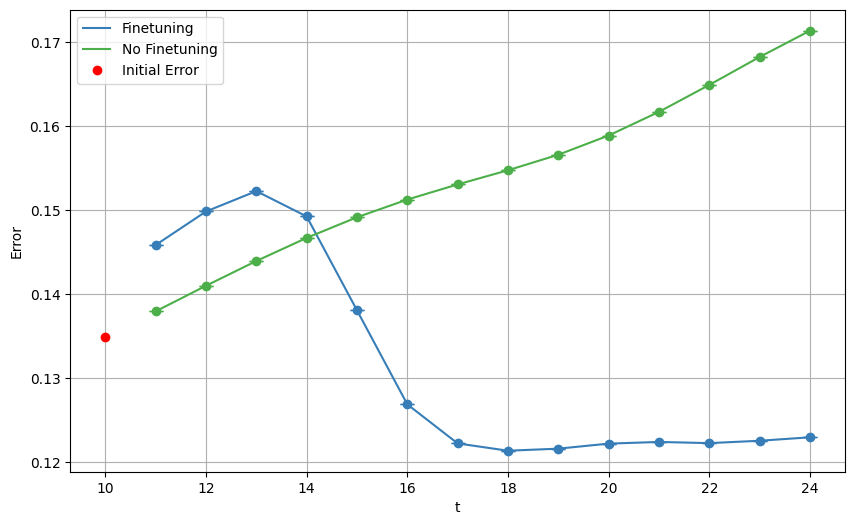

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

color = '#377eb8'
ax.plot(t_list, err_ft_mean, label='Finetuning', color=color)
ax.errorbar(t_list, err_ft_mean, yerr=err_ft_margin, fmt='o', capsize=5, color=color)

color = '#4daf4a'
ax.plot(t_list, err_noft_mean, label='No Finetuning', color=color)
ax.errorbar(t_list, err_noft_mean, yerr=err_noft_margin, fmt='o', capsize=5, color=color)


ax.plot([t_pretrain], [err_init_mean], 'ro', label='Initial Error')

ax.set_xlabel('t')
ax.set_ylabel('Error')
ax.legend()
ax.grid(True)
plt.show()

In [26]:
results = {
    'err_ft_mean': err_ft_mean.tolist(),
    'err_noft_mean': err_noft_mean.tolist(),
    'err_init_mean': err_init_mean.tolist(),
    'err_ft_std': err_ft_std.tolist(),
    'err_noft_std': err_noft_std.tolist(),
    'err_init_std': err_init_std.tolist(), 
    't_list': t_list.tolist()
}

filename = f'results/h{hidden_size}_ignore_ptd.json' if ignore_pretrained_data else f'results/h{hidden_size}.json'
with open(filename, 'w') as f:
    json.dump(results, f, indent=4)

### Single Seed

In [24]:
err_init

[np.float32(0.13944052), np.float32(0.09663317), np.float32(0.13812982)]

In [114]:
X, Y, _ = generate_sequence(sf=sample_rate)

In [115]:
err_ft_list = []
err_noft_list = []

pretrained_state_dict, initial_error = pretrain((X, Y), t_pretrain, hp_pretrain, sample_rate)

for t in t_list:
    print(f"t = {t}")
    err = run_at_time((X, Y), t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=False, finetune=True)
    err_ft_list.append(err)

    err = run_at_time((X, Y), t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=False, finetune=False)
    err_noft_list.append(err)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 20.18it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 41.76it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 18.48it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:13<00:00,  7.63it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


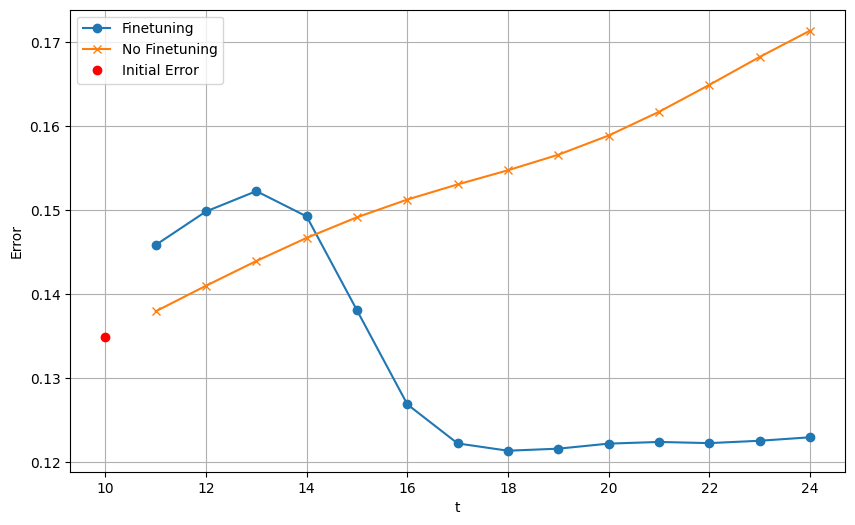

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(t_list, err_ft_list, label='Finetuning', marker='o')
plt.plot(t_list, err_noft_list, label='No Finetuning', marker='x')
plt.plot([t_pretrain], [initial_error], 'ro', label='Initial Error')
plt.xlabel('t')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

### Make plots

In [14]:
num_reps = 3
t_pretrain = 10

In [32]:
def read_from_json(file):
    with open(f'results/{file}.json', 'r') as f:
        results = json.load(f)
    return results

def make_plot(ax, results, hidden_size, ls):
    t_list = np.array(results['t_list'])
    err_ft_mean = np.array(results['err_ft_mean'])
    err_noft_mean = np.array(results['err_noft_mean'])
    err_init_mean = np.array(results['err_init_mean'])
    err_ft_std = np.array(results['err_ft_std'])
    err_noft_std = np.array(results['err_noft_std'])
    err_init_std = np.array(results['err_init_std'])

    t_list = np.concatenate(([t_pretrain], t_list))
    err_ft_mean = np.concatenate(([err_init_mean], err_ft_mean))
    err_noft_mean = np.concatenate(([err_init_mean], err_noft_mean))
    err_ft_std = np.concatenate(([err_init_std], err_ft_std))
    err_noft_std = np.concatenate(([err_init_std], err_noft_std))

    # Calculate 95% confidence interval for error bars
    z_score = 1.96
    err_ft_margin = z_score * err_ft_std / np.sqrt(num_reps)
    err_noft_margin = z_score * err_noft_std / np.sqrt(num_reps)

    color = '#377eb8'
    ax.plot(t_list, err_ft_mean, label=f'Finetuning (h = {hidden_size})', color=color, ls=ls)
    ax.errorbar(t_list, err_ft_mean, yerr=err_ft_margin, fmt='o', capsize=5, color=color)

    color = '#4daf4a'
    ax.plot(t_list, err_noft_mean, label=f'No Finetuning (h = {hidden_size})', color=color, ls=ls)
    ax.errorbar(t_list, err_noft_mean, yerr=err_noft_margin, fmt='o', capsize=5, color=color)

    # ax.plot([t_pretrain], [err_init_mean], 'ro', label=f'Initial Error (h = {hidden_size})')


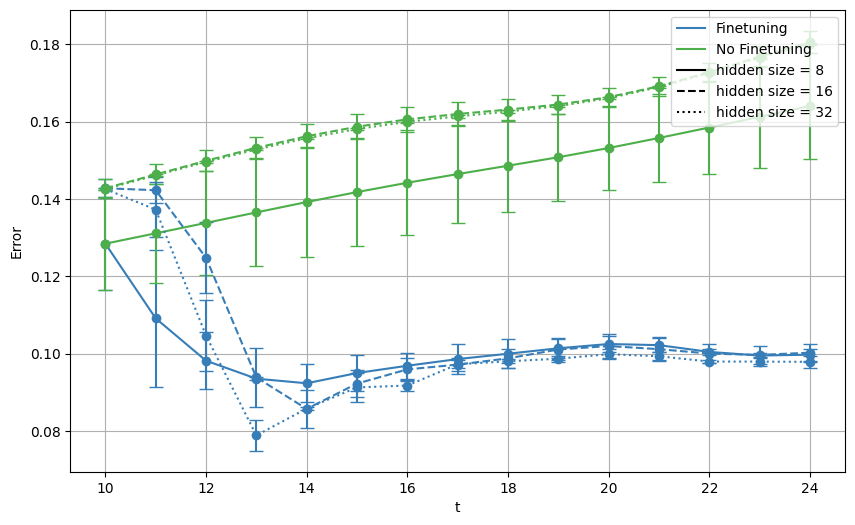

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

results = read_from_json('h8_ignore_ptd_var_seeds')
make_plot(ax, results, hidden_size=8, ls='-')

results = read_from_json('h16_ignore_ptd_var_seeds')
make_plot(ax, results, hidden_size=16, ls='--')

results = read_from_json('h32_ignore_ptd_var_seeds')
make_plot(ax, results, hidden_size=32, ls=':')

legend_elements = [
    Line2D([0], [0], color='#377eb8', label='Finetuning'),
    Line2D([0], [0], color='#4daf4a', label='No Finetuning'),
    Line2D([0], [0], color='k', ls='-', label='hidden size = 8'),
    Line2D([0], [0], color='k', ls='--', label='hidden size = 16'),
    Line2D([0], [0], color='k', ls=':', label='hidden size = 32')
]

ax.set_xlabel('t')
ax.set_ylabel('Error')
ax.legend(handles=legend_elements, loc='upper right')
ax.grid(True)
plt.show()